In [30]:
import rqalpha as rqa
import rqdatac as rqd
import rqoptimizer as rqo
import utils
from datetime import datetime
import pickle
import os
import matplotlib.pyplot as plt
plt.style.use('ggplot')
rqd.init()

F:\anaconda\envs\ricequant\lib\site-packages\rqdatac\client.py:190: UserWarning: rqdatac is already inited. Settings will be changed.
  warnings.warn("rqdatac is already inited. Settings will be changed.", stacklevel=0)


In [2]:
def init(context):
    pass

In [37]:
def cal_score(close, indicator):
    close_list = close.tolist()
    total_score = 0
    for i, price in enumerate(close_list):
        score = 1
        if i == len(close_list) - 1:
            break
        # 等差数列
        arithmetic = np.linspace(price, close_list[-1], len(close_list) - i)
        # 比较序列
        compare = close_list[i:]
        if indicator == 'peak':
            # 有大于等差数列的得分为0
            condition = np.where(compare > arithmetic, 1, 0).sum()
        elif indicator == 'trough':
            condition = np.where(compare < arithmetic, 1, 0).sum()
        if condition > 0:
            score = 0
        total_score += score
    return total_score

def visualize(daily_price, threshold, title):
    dp = daily_price.copy()
    dp['buy_signal'] = np.where(dp['trough'] >= threshold, dp['close'], np.nan)
    dp['sell_signal'] = np.where(dp['peak'] >= threshold, dp['close'], np.nan)
    plt.figure(figsize=(20, 6))
    plt.style.use('ggplot')
    plt.plot(dp.index, dp['close'], 'k-')
    plt.plot(dp.index, dp['buy_signal'], 'r.', ms=13, alpha=0.8)
    plt.plot(dp.index, dp['sell_signal'], 'gs', ms=8, alpha=0.8)
    plt.title(title, fontsize=20)

In [9]:
start = datetime.now()
start_date = '2017-01-01'
end_date = '2020-09-01'
window = 60

dates = rqd.get_trading_dates(start_date, end_date)

universe = ['000985.XSHG','000905.XSHG','000300.XSHG']

In [11]:
close_df0 = rqd.get_price(universe, start_date=start_date, end_date=end_date, fields='close', expect_df=True)

In [24]:
close_df = close_df0.copy()

In [25]:
close_df.sort_index(inplace=True)

In [26]:
close_df

close
order_book_id date                 
000300.XSHG   2017-01-03  3342.2272
              2017-01-04  3368.3117
              2017-01-05  3367.7892
              2017-01-06  3347.6665
              2017-01-09  3363.9014
...                             ...
000985.XSHG   2020-08-26  5393.7227
              2020-08-27  5438.7601
              2020-08-28  5541.3481
              2020-08-31  5525.2146
              2020-09-01  5556.5008

[2679 rows x 1 columns]

In [27]:
close_df['trough']=close_df['close'].groupby(level=0).rolling(window).apply(
    cal_score,kwargs={'indicator':'trough'}).values
close_df['peak']=close_df['close'].groupby(level=0).rolling(window).apply(
    cal_score,kwargs={'indicator':'peak'}).values

In [28]:
close_df

close  trough  peak
order_book_id date                               
000300.XSHG   2017-01-03  3342.2272     NaN   NaN
              2017-01-04  3368.3117     NaN   NaN
              2017-01-05  3367.7892     NaN   NaN
              2017-01-06  3347.6665     NaN   NaN
              2017-01-09  3363.9014     NaN   NaN
...                             ...     ...   ...
000985.XSHG   2020-08-26  5393.7227    15.0   1.0
              2020-08-27  5438.7601     1.0   2.0
              2020-08-28  5541.3481     1.0   6.0
              2020-08-31  5525.2146     3.0   1.0
              2020-09-01  5556.5008     3.0   4.0

[2679 rows x 3 columns]

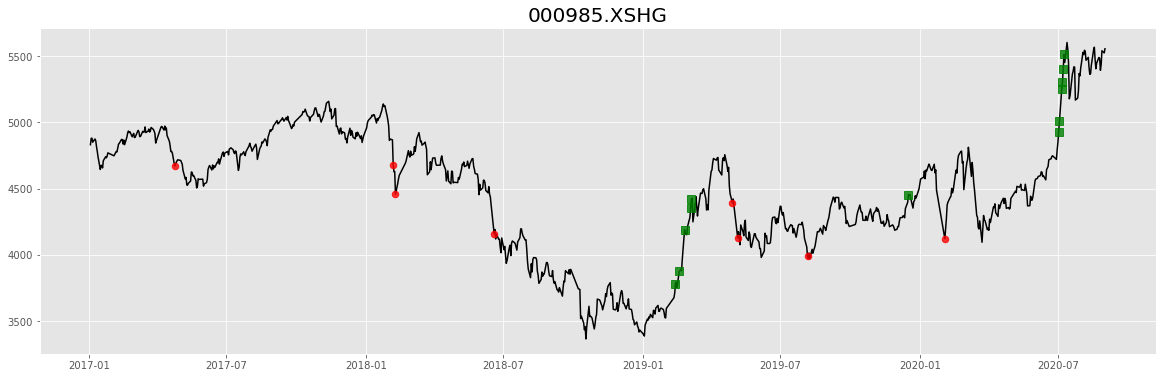

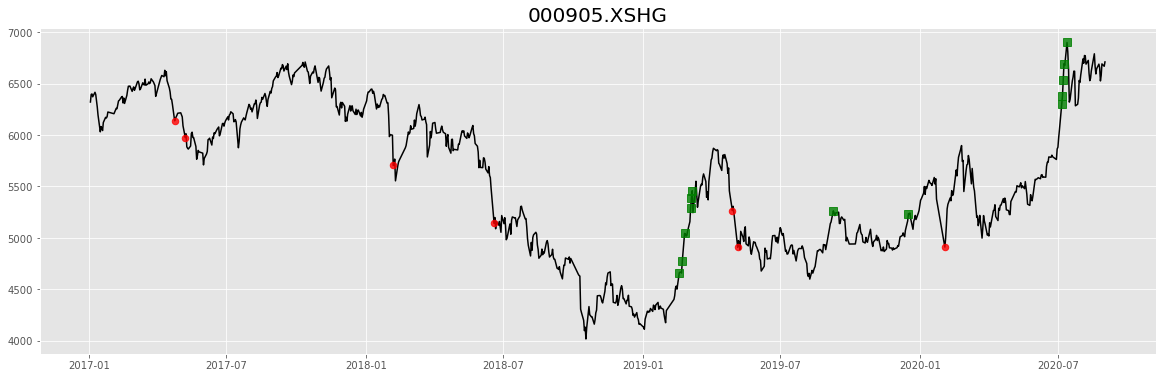

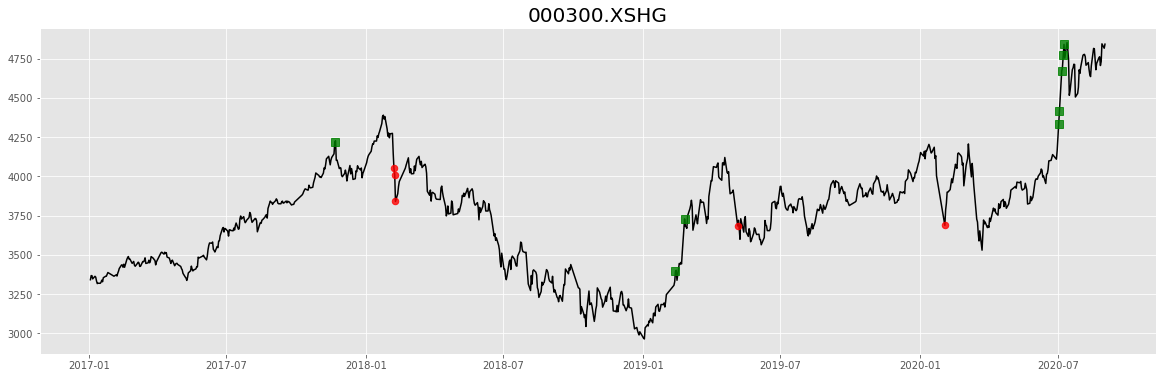

In [38]:
for i in universe:
    visualize(close_df.loc[i],25,i)